In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
if "../src" not in sys.path:
    sys.path.append("../src")

In [73]:
import matplotlib.pyplot as plt
from dietcoke import Corpus, Text
from itertools import islice, chain, groupby

corpus = Corpus('tier1')
corpus.read_corpus()

In [96]:
text0 = ""
dyns = []
text_corpus = [Text(corpus.corpus[i]) 
               for i in range(0, len(corpus.corpus), 10)]
text_corpus = sorted(text_corpus, key=lambda x: int(x.obj.get("dynFromId", -1)))
for text_obj in text_corpus:    
    text_x = "".join(text_obj.text)    
    dyns.append((len(text0), 
                 text_obj.obj.get("dynFrom", ""), 
                 text_obj.obj.get("title", "")))
    text0 += text_x

In [97]:
dyns

[(0, 'Warring States', '戰國策'),
 (121743, 'Warring States', '韓非子'),
 (227974, 'Warring States', '竹書紀年'),
 (237102, 'Western Han', '淮南子'),
 (367841, 'Western Han', '春秋穀梁傳'),
 (408670, 'Eastern Han', '釋名'),
 (430094, 'Eastern Han', '東觀漢記'),
 (508610, 'Eastern Han', '吳越春秋'),
 (547736, 'Eastern Han', '蔡中郎集'),
 (606101, 'Eastern Han', '文子'),
 (645306, 'Northern and Southern', '金樓子'),
 (692479, 'Northern Song', '太平廣記')]

In [98]:
dyn_splits = [(list(grp)[0][0], k) for k, grp in groupby(dyns, key=lambda x: x[1])]

In [99]:
dyn_splits

[(0, 'Warring States'),
 (237102, 'Western Han'),
 (408670, 'Eastern Han'),
 (645306, 'Northern and Southern'),
 (692479, 'Northern Song')]

In [100]:
len(text0)

2268668

In [101]:
from itertools import islice
def batch(iterable, n_batch, drop_last=False):
    it = iter(iterable)
    for i, x in enumerate(iter(lambda: list(islice(it, n_batch)), [])):
        if drop_last and len(x) != n_batch:
            break
        yield i, x

In [148]:
"abcabc".index("a", 2)

3

In [149]:
def get_occurences(text, probe):
    occs = []
    offset = -1
    while True:
        try:
            offset = text.index(probe, offset+1)
            occs.append(offset)
        except ValueError:
            break
    return occs

In [151]:
def getV(text):
    return len(set(text))

def get_chunked_V(text, prevV=set()):
    Vset = set() | prevV
    xs = []
    ys = []
    N_CHUNK = 5000
    for i, chunk in batch(text, N_CHUNK):
        xs.append(i*N_CHUNK)
        Vset |= set(chunk)
        ys.append(len(Vset))
    return (xs, ys, Vset)

def get_cond_chunked_V(text, cond, prevV=set()):
    Vset = set() | prevV
    xs = []
    ys = []
    N_CHUNK = 5000
    for i, chunk in batch(text, N_CHUNK):
        xs.append(i*N_CHUNK)
        if cond in chunk:
            cond_set = set()
            for offset in get_occurences(chunk, cond):
                if offset+1 >= len(chunk): continue
                cond_set.add(chunk[offset+1])
            Vset |= set(cond_set)
        else:
            pass
        ys.append(len(Vset))
    return (xs, ys, Vset)

In [103]:
import random
from tqdm.auto import tqdm

## Overall

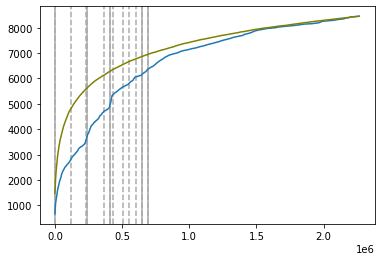

In [133]:
import numpy as np
for x, d in dyn_splits:
    plt.axvline(x, linestyle="solid", color="#AAA")
for x, d, _ in dyns:
    plt.axvline(x, linestyle="dashed", color="#AAA")

trend_x, trend_y, _ = get_chunked_V(text0)
plt.plot(trend_x, trend_y)
xr, yr = [], []
for i in tqdm(range(2)):
    text_x = list(text0)
    random.shuffle(text_x)
    xs_i, ys_i, _ = get_chunked_V(text_x)
    xr.append(xs_i)
    yr.append(ys_i)
xr = np.array(xr[0])
yr = np.array(yr).mean(0)
plt.plot(xr, yr, color="olive")

In [113]:
breaks = [x[0] for x in dyn_splits] + [len(text0)]
for s, e in zip(breaks, breaks[1:]):
    print(s,e)

0 237102
237102 408670
408670 645306
645306 692479
692479 2268668


In [129]:
xs, ys = [], []
for i in tqdm(range(1)):    
    breaks = [x[0] for x in dyn_splits] + [len(text0)]
    xs_i, ys_i = [], []
    prevV = set()
    for s, e in zip(breaks, breaks[1:]):
        text_x = list(text0[s:e])
        random.shuffle(text_x)
        bx, by, prevV = get_chunked_V(text_x, prevV)
        bx = [x+s for x in bx]
        xs_i.extend(bx)
        ys_i.extend(by)
    xs.append(xs_i)
    ys.append(ys_i)
xs = np.array(xs[0])
ys = np.array(ys).mean(0)

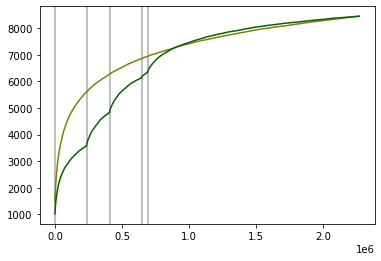

In [134]:
for x, d in dyn_splits:
    plt.axvline(x, linestyle="solid", color="#AAA")
for x, d, _ in dyns:
    pass
    #plt.axvline(x, linestyle="dashed", color="#AAA")
# plt.plot(trend_x, trend_y, color="#9AF")
plt.plot(xr, yr, color="olive")
plt.plot(xs, ys, color="darkgreen")

## Conditional

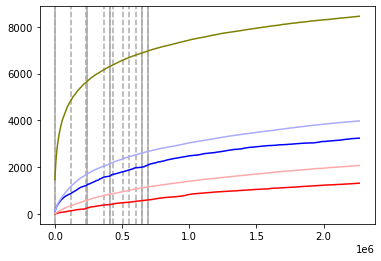

In [164]:
import numpy as np
for x, d in dyn_splits:
    plt.axvline(x, linestyle="solid", color="#AAA")
for x, d, _ in dyns:
    plt.axvline(x, linestyle="dashed", color="#AAA")

xs_da, ys_da, _ = get_cond_chunked_V(text0, "大")
plt.plot(xs_da, ys_da, label="Da", color="red")

xs_zhi, ys_zhi, _ = get_cond_chunked_V(text0, "之")
plt.plot(xs_zhi, ys_zhi, label="Zhi", color="blue")

# Random permutation of conditional V - "大"
xr, yr = [], []
for i in tqdm(range(2)):
    text_x = list(text0)
    random.shuffle(text_x)
    xs_i, ys_i, _ = get_cond_chunked_V(text_x, "大")
    xr.append(xs_i)
    yr.append(ys_i)
xr_da = np.array(xr[0])
yr_da = np.array(yr).mean(0)
plt.plot(xr_da, yr_da, color="#FAA")

# Random permutation of conditional V - "之"
xr, yr = [], []
for i in tqdm(range(2)):
    text_x = list(text0)
    random.shuffle(text_x)
    xs_i, ys_i, _ = get_cond_chunked_V(text_x, "之")
    xr.append(xs_i)
    yr.append(ys_i)
xr_zhi = np.array(xr[0])
yr_zhi = np.array(yr).mean(0)
plt.plot(xr_zhi, yr_zhi, color="#AAF")

# Random permutation of V
xr, yr = [], []
for i in tqdm(range(2)):
    text_x = list(text0)
    random.shuffle(text_x)
    xs_i, ys_i, _ = get_chunked_V(text_x)
    xr.append(xs_i)
    yr.append(ys_i)
xr = np.array(xr[0])
yr = np.array(yr).mean(0)
plt.plot(xr, yr, color="olive")

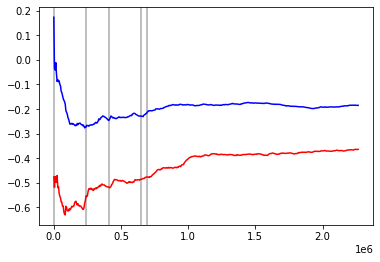

In [171]:
for x, d in dyn_splits:
    plt.axvline(x, linestyle="solid", color="#AAA")
plt.plot(xs_da, (ys_da - yr_da)/yr_da, color="red")
plt.plot(xs_zhi, (ys_zhi - yr_zhi)/yr_zhi, color="blue")